In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gudhi as gd
from sklearn.decomposition import PCA
from skimage.filters import gaussian
from tqdm.notebook import tqdm
import glob

from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import StrMethodFormatter
import matplotlib
import seaborn as sns
sns.set_style("whitegrid")
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['font.size'] = 20
matplotlib.rcParams['axes.axisbelow'] = True
matplotlib.rcParams.update({'figure.autolayout': True})

In [2]:
paths = glob.glob(r"C:\Users\17345\Documents\Manuscripts\MD_Sim_Topology_Project\MD_Sim_Topology_Project_code\MD_Sim_Topology_Project\2d_SAM\Idealized SAMs\*")

In [3]:
adj_label = []
for path in paths:
    adj = np.load(path,allow_pickle = True)
    adj_label.append(adj.get('label'))
    
zippath = zip(adj_label,paths)
sort_path = sorted(zippath, key = lambda t: t[0])

In [4]:
adj_label_sort = []
path_sort = []
for i in range(len(sort_path)):
    adj_label_sort.append(sort_path[i][0])
    path_sort.append(sort_path[i][1])

In [5]:
EC_adj = []
info = []
for path in tqdm(path_sort):
    dic = np.load(path, allow_pickle = True)
    for i in range(8000):
        A = dic.get('adj')[i]
        EC_adj.append(np.shape(A)[0] - np.sum(A)/2)
        info.append(dic.get('ligand').split('_'))
        
EC_adj = np.stack(EC_adj)

  0%|          | 0/40 [00:00<?, ?it/s]

In [6]:
X = np.load('X_train_new.pickle',allow_pickle = True)
Y = np.load('Y_train_new.pickle',allow_pickle = True)

In [7]:
ziplist = zip(Y,X)
sort = sorted(ziplist, key = lambda t: t[0])

In [8]:
Y_sort = []
X_sort = []
for i in range(len(sort)):
    Y_sort.append(sort[i][0])
    X_sort.append(sort[i][1])

In [9]:
X = np.array(X_sort)
Y = np.array(Y_sort)

In [10]:
# returns an entire euler characteristic curve for a given time point over the full range of filtration values
def get_euler_characteristic(data,samples):
    curves = []
    filtration_increment = 5e-3;
    numIndices = int(1/filtration_increment) + 1;
    filtrations = np.linspace(0,.5,numIndices)
    for j in tqdm(range(samples)):
        euler_characteristic = np.zeros(numIndices);
#         dataf = (data[j] - np.min(data[j]))/(np.max(data[j]) - np.min(data[j]))
#         dataf = gaussian(dataf,sigma = .1)
        dataf = data[j]
        cubeplex = gd.CubicalComplex(dimensions = [np.shape(dataf)[0],np.shape(dataf)[0]],top_dimensional_cells=np.ndarray.flatten(dataf))
        cubeplex.persistence();
        for i in range(numIndices):
            filtration_value = filtrations[i];
            betti_numbers = cubeplex.persistent_betti_numbers(filtration_value,filtration_value);
            euler_characteristic[i] = betti_numbers[0] - betti_numbers[1];
        curves.append(euler_characteristic)
    return curves;

In [11]:
#Create Time Averaged Density Fields

samp = 200

Xavg = []
ECavg = []
Yavg = []
info_avg = []


for i in range(int(320000/samp)):
    ECavg.append(np.sum(EC_adj[i*samp : (i+1)*samp])/samp)
    Xavg.append(np.sum(X[i*samp : (i+1)*samp,:,:,0],0)/samp)
    Yavg.append(np.sum(Y[i*samp : (i+1)*samp])/samp)
    info_avg.append(info[i*samp])

In [12]:
samples = int(320000/samp)
ECs = get_euler_characteristic(Xavg,samples)

  0%|          | 0/1600 [00:00<?, ?it/s]

In [13]:
EC_curve = np.vstack(ECs)
ECz = np.vstack([EC_curve.T,ECavg])
ECz = ECz.T

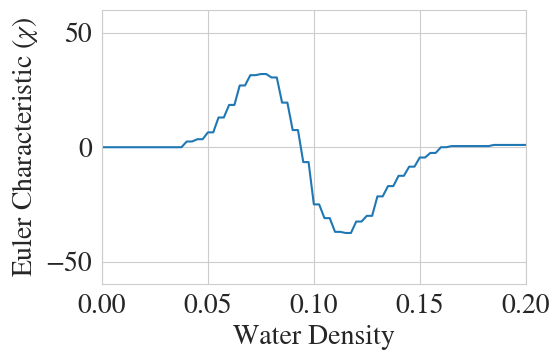

In [14]:
filtration_increment = 5e-3;
numIndices = int(1/filtration_increment) + 1;
filtrations = np.linspace(0,.5,numIndices)

plt.figure(dpi = 100)

plt.plot(filtrations,np.mean(EC_curve[0:2],axis = 0))

plt.xlim(0,.2)

plt.ylim(-60,60)

plt.xlabel("Water Density")

plt.ylabel("Euler Characteristic ($\chi$)")

plt.savefig("EC_For_Example.svg")

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVR

x_train,x_test,y_train,y_test,descrip,descrip_pred = train_test_split(ECz,Yavg,info_avg,test_size = 0.3)

mdl = LinearSVR(C = 10, dual = False,loss = 'squared_epsilon_insensitive')

mdl.fit(x_train,y_train)

a = mdl.predict(x_test)

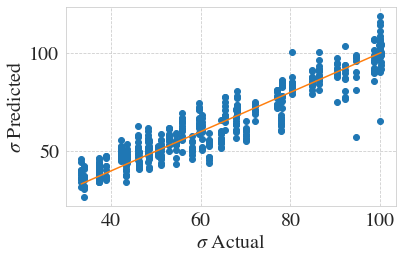

In [16]:
plt.plot(y_test,a,'o',label = "Data")

plt.plot([np.min(y_test),np.max(y_test)],[np.min(y_test),np.max(y_test)])

plt.ylabel("$\sigma$ Predicted")
plt.xlabel("$\sigma$ Actual")
plt.grid(True,ls = '--')

In [17]:
mse = np.sqrt((a - y_test)**2)
np.sum(mse)/len(y_test)

np.corrcoef(a,y_test)**2

array([[1.       , 0.8823793],
       [0.8823793, 1.       ]])

In [18]:
descr_list = np.unique(descrip_pred,axis = 0)

mean_val = []
std_val = []
label_val = []
for i in descr_list:
    vals = []
    label = []
    count = 0
    for j in descrip_pred:
        if (j==i).all():
            vals.append(a[count])
            label.append(y_test[count])
        count+=1
    mean_val.append(np.mean(vals))
    std_val.append(np.std(vals))
    label_val.append(np.mean(label))

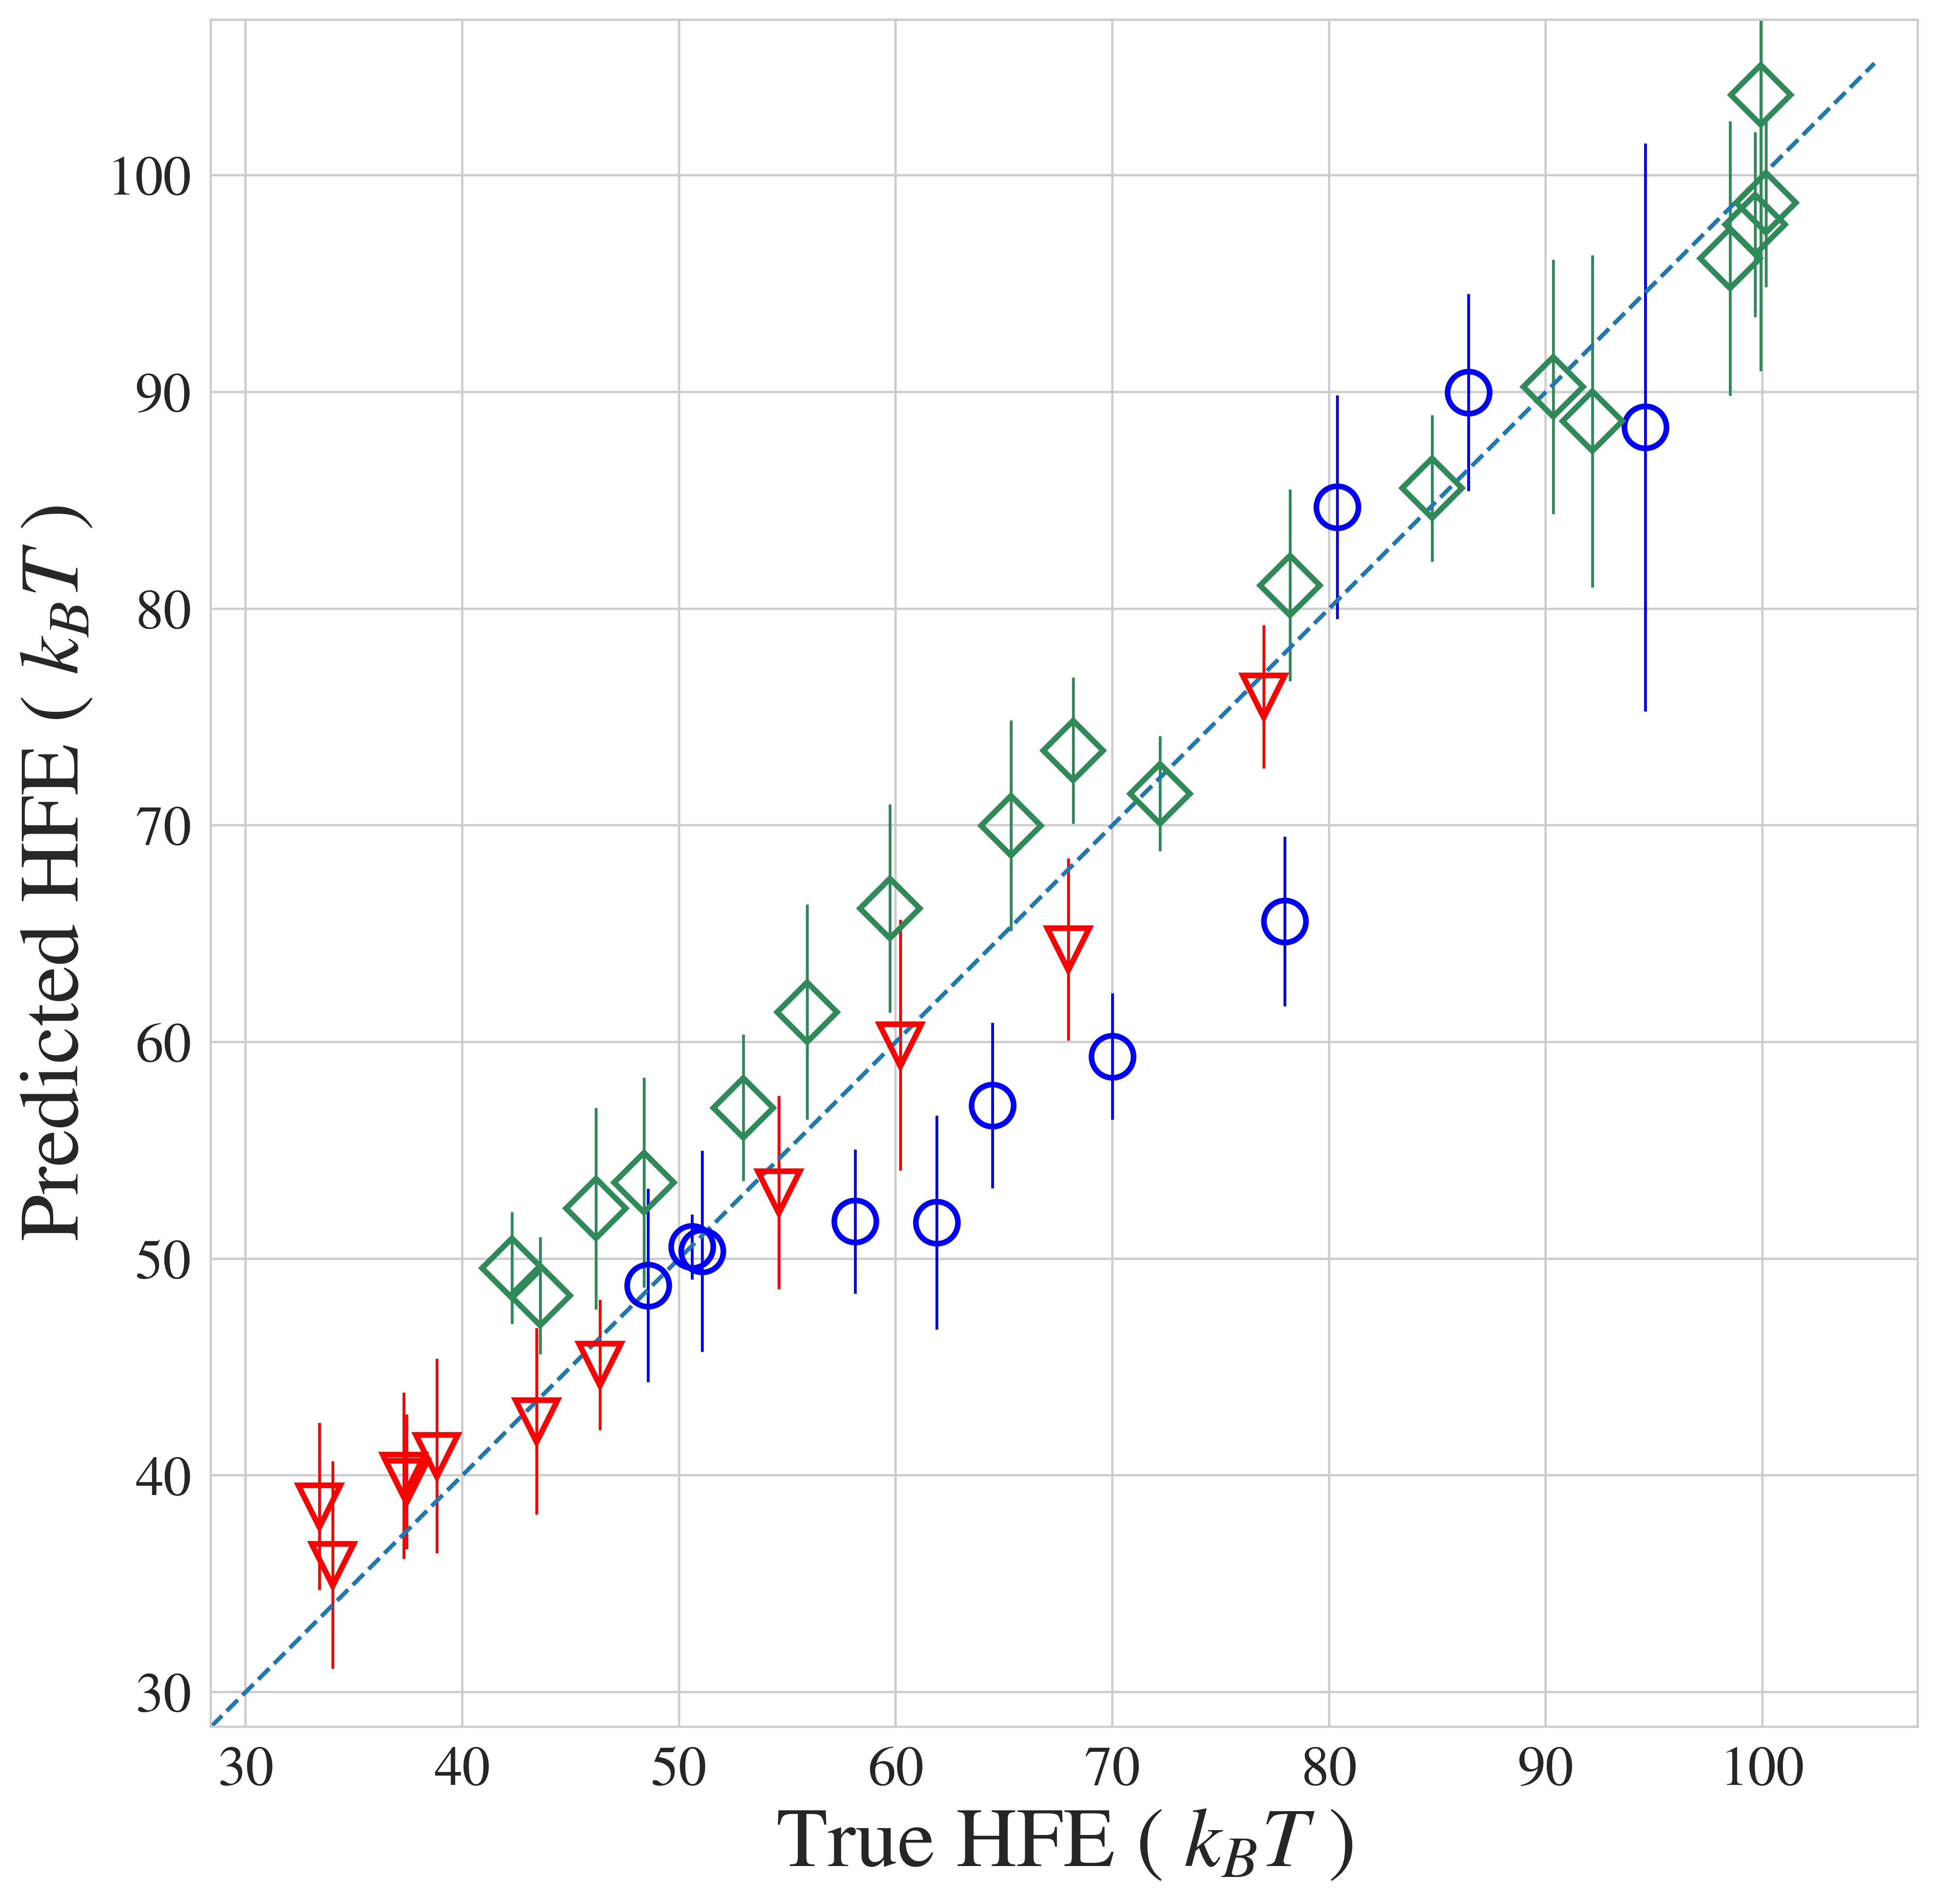

In [19]:
from matplotlib.markers import MarkerStyle
plt.figure(figsize=(10, 10), dpi=500)
cmap = matplotlib.cm.get_cmap('coolwarm')

descrip = np.unique(descrip_pred,axis = 0)

for i in range(40):
    
    if descrip[i][1] == 'amide-dodecanethiol':
        marker = MarkerStyle('o', fillstyle = 'none')
        label = "Amide"
        color = 'b'
    elif descrip[i][1] == 'amine-tridecanethiol':
        marker = MarkerStyle('v', fillstyle = 'none')
        label = "Amine"
        color = 'r'
    elif descrip[i][1] == 'hydroxy-undecanethiol':
        marker = MarkerStyle('D', fillstyle = 'none')
        label = "Hydroxyl"
        color = 'seagreen'
          
    plt.errorbar(label_val[i],mean_val[i],yerr = std_val[i],linewidth = 1,linestyle='',marker = marker,markersize = 15,markeredgewidth=2,c = color)
    
plt.xlabel(r"True HFE $(\ k_{B}T\ )$",fontsize = 30)
plt.ylabel(r"Predicted HFE $(\ k_{B}T\ )$",fontsize = 30)

plt.xlim(np.min(label_val)-5,np.max(label_val)+7)
plt.ylim(np.min(label_val)-5,np.max(label_val)+7)
plt.gca().set_aspect('equal', adjustable='box')

plt.plot([np.min(label_val)-5,np.max(label_val)+5],[np.min(label_val)-5,np.max(label_val)+5],'--')

norm = matplotlib.colors.Normalize(vmin=0,vmax=1)

plt.savefig("train_reg_SAM.svg")

In [20]:
mdl = LinearSVR(C = 10, dual = False,loss = 'squared_epsilon_insensitive')

mdl.fit(ECz,Yavg)

LinearSVR(C=10, dual=False, loss='squared_epsilon_insensitive')

# TESTING SETS

In [21]:
paths = glob.glob(r"C:\Users\17345\Documents\Manuscripts\MD_Sim_Topology_Project\MD_Sim_Topology_Project_code\MD_Sim_Topology_Project\2d_SAM\Idealized Test SAMs\*")

In [22]:
adj_label = []
for path in paths:
    adj = np.load(path,allow_pickle = True)
    adj_label.append(adj.get('label'))
    
zippath = zip(adj_label,paths)
sort_path = sorted(zippath, key = lambda t: t[0])

In [23]:
adj_label_sort = []
path_sort = []
for i in range(len(sort_path)):
    adj_label_sort.append(sort_path[i][0])
    path_sort.append(sort_path[i][1])

In [24]:
EC_adj = []
info = []
for path in tqdm(path_sort):
    dic = np.load(path, allow_pickle = True)
    for i in range(8000):
        A = dic.get('adj')[i]
        EC_adj.append(np.shape(A)[0] - np.sum(A)/2)
        info.append(dic.get('ligand').split('_'))
        
EC_adj = np.stack(EC_adj)

  0%|          | 0/10 [00:00<?, ?it/s]

In [25]:
X = np.load('X_test_new.pickle',allow_pickle = True)
Y = np.load('Y_test_new.pickle',allow_pickle = True)

In [26]:
ziplist = zip(Y,X)
sort = sorted(ziplist, key = lambda t: t[0])

In [27]:
Y_sort = []
X_sort = []
for i in range(len(sort)):
    Y_sort.append(sort[i][0])
    X_sort.append(sort[i][1])

In [28]:
X = np.array(X_sort)
Y = np.array(Y_sort)

In [29]:
#Create Time Averaged Density Fields

samp = 200

Xavg = []
ECavg = []
Yavg = []
info_avg = []


for i in range(int(80000/samp)):
    ECavg.append(np.sum(EC_adj[i*samp : (i+1)*samp])/samp)
    Xavg.append(np.sum(X[i*samp : (i+1)*samp,:,:,0],0)/samp)
    Yavg.append(np.sum(Y[i*samp : (i+1)*samp])/samp)
    info_avg.append(info[i*samp])

In [30]:
samples = int(80000/samp)
ECs = get_euler_characteristic(Xavg,samples)

  0%|          | 0/400 [00:00<?, ?it/s]

In [31]:
EC_curve = np.vstack(ECs)
ECz = np.vstack([EC_curve.T,ECavg])
ECz = ECz.T

In [32]:
a = mdl.predict(ECz)

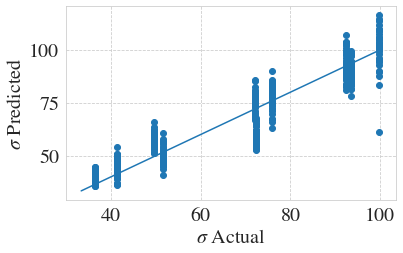

In [33]:
plt.scatter(Yavg,a)
plt.plot([np.min(y_test),np.max(y_test)],[np.min(y_test),np.max(y_test)])

plt.ylabel("$\sigma$ Predicted")
plt.xlabel("$\sigma$ Actual")
plt.grid(True,ls = '--')

In [34]:
mse = np.sqrt((a - Yavg)**2)
np.sum(mse)/len(y_test)

4.961519901009595

In [35]:
np.corrcoef(a,Yavg)**2

array([[1.        , 0.88158696],
       [0.88158696, 1.        ]])

In [36]:
descr_list = np.unique(info_avg,axis = 0)

mean_val = []
std_val = []
label_val = []
for i in descr_list:
    vals = []
    label = []
    count = 0
    for j in info_avg:
        if (j==i).all():
            vals.append(a[count])
            label.append(Yavg[count])
        count+=1
    mean_val.append(np.mean(vals))
    std_val.append(np.std(vals))
    label_val.append(np.mean(label))

10

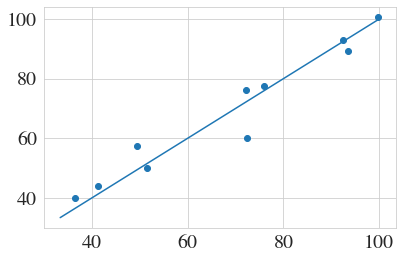

In [37]:
plt.scatter(label_val,mean_val)

plt.plot([np.min(y_test),np.max(y_test)],[np.min(y_test),np.max(y_test)])

len(label_val)

In [38]:
descr_list

array([['wc', 'amide-dodecanethiol', 'k0.25'],
       ['wc', 'amide-dodecanethiol', 'k0.65'],
       ['wc', 'amide-dodecanethiol', 'k0.95'],
       ['wc', 'amine-tridecanethiol', 'k0.15'],
       ['wc', 'amine-tridecanethiol', 'k0.45'],
       ['wc', 'amine-tridecanethiol', 'k0.95'],
       ['wc', 'hydroxy-undecanethiol', 'k0.35'],
       ['wc', 'hydroxy-undecanethiol', 'k0.675'],
       ['wc', 'hydroxy-undecanethiol', 'k0.83'],
       ['wc', 'hydroxy-undecanethiol', 'k0.95']], dtype='<U21')

# End of Test

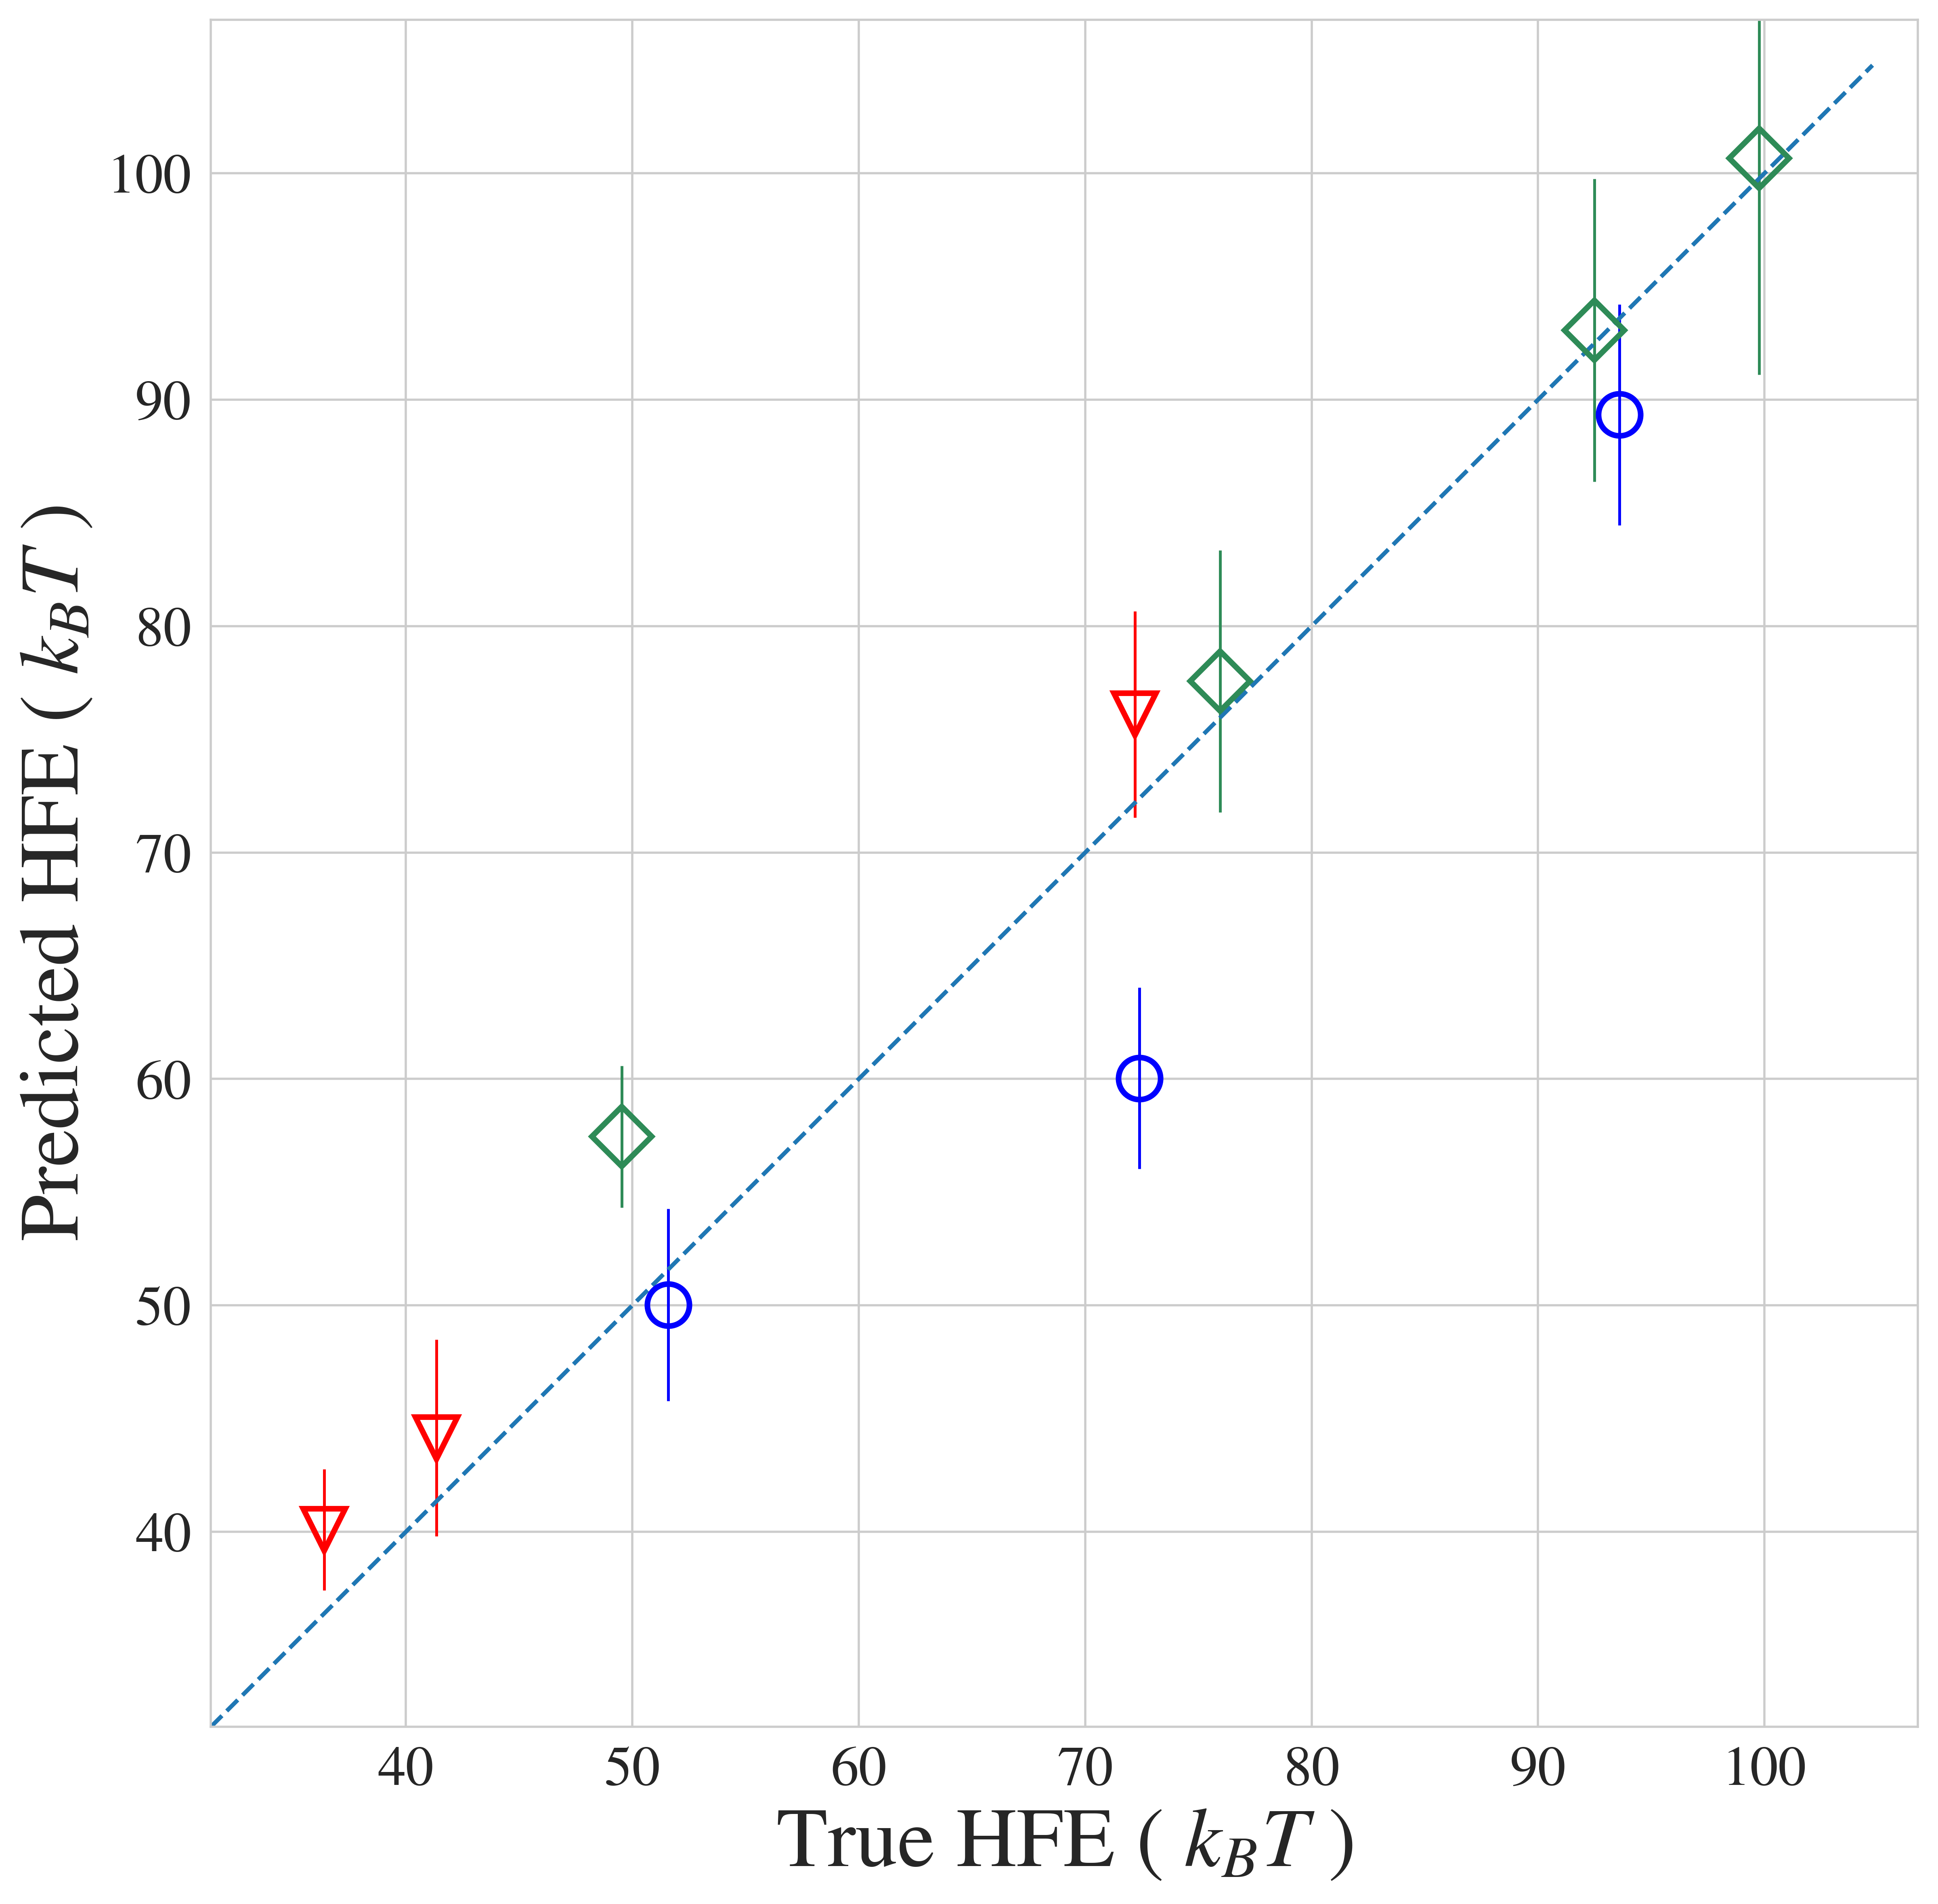

In [44]:
from matplotlib.markers import MarkerStyle
plt.figure(figsize=(10, 10), dpi=500)
cmap = matplotlib.cm.get_cmap('coolwarm')

descrip = np.unique(info_avg,axis = 0)

for i in range(10):
    
    if descrip[i][1] == 'amide-dodecanethiol':
        marker = MarkerStyle('o', fillstyle = 'none')
        label = "Amide"
        color = 'b'
    elif descrip[i][1] == 'amine-tridecanethiol':
        marker = MarkerStyle('v', fillstyle = 'none')
        label = "Amine"
        color = 'r'
    elif descrip[i][1] == 'hydroxy-undecanethiol':
        marker = MarkerStyle('D', fillstyle = 'none')
        label = "Hydroxyl"
        color = 'seagreen'
    
    plt.errorbar(label_val[i],mean_val[i],yerr = std_val[i],linewidth = 1,c = color,linestyle='',marker = marker,markersize = 15,markeredgewidth=2)
    
plt.xlabel(r"True HFE $(\ k_{B}T\ )$",fontsize = 30)
plt.ylabel(r"Predicted HFE $(\ k_{B}T\ )$",fontsize = 30)

plt.xlim(np.min(label_val)-5,np.max(label_val)+7)
plt.ylim(np.min(label_val)-5,np.max(label_val)+7)
plt.gca().set_aspect('equal', adjustable='box')

plt.plot([np.min(label_val)-5,np.max(label_val)+5],[np.min(label_val)-5,np.max(label_val)+5],'--')

plt.savefig("test_reg_SAM.svg")

In [40]:
mse = np.sqrt((a - y_test)**2)
np.sum(mse)/len(y_test)

ValueError: operands could not be broadcast together with shapes (400,) (480,) 

In [ ]:
#kbT vs. EC
plt.figure(dpi=500)
filtration_increment = 5e-3;
numIndices = int(1/filtration_increment) + 1;
filtrations = np.linspace(0,1,numIndices)

#90 = 46

#310 = 85

#210 = 100

i = 5

plt.plot(filtrations,EC_curve[i],'-',c = "tab:red",label = r'HFE=33 $k_{B}T$')

print(Yavg[150])

plt.xlim(0,.2)

plt.legend(fontsize = 13)

plt.xlabel("Water Density")

plt.ylabel('Euler Characteristic')

plt.savefig("EC_t{}.svg".format(i))

In [ ]:
EC_adj[1]

In [ ]:
plt.imshow(A)

In [ ]:
EC_adj = []
info = []
for path in tqdm(path_sort):
    dic = np.load(path, allow_pickle = True)
    for i in range(8000):
        A = dic.get('adj')[i]
        EC_adj.append(np.shape(A[0:-2,0:-2])[0] - np.sum(A[0:-2,0:-2])/2)
        info.append(dic.get('ligand').split('_'))
        
EC_adj = np.stack(EC_adj)

In [ ]:
EC_adj[5]